# 1. Compositional Data
Compiled by [Morgan Williams](mailto:morgan.williams@csiro.au) for C3DIS 2018 

Geochemical data is compositional in nature, meaning that values are relative and subject to closure (i.e. they sum to 100%). This leads to spurious correlation (e.g. for two variable compositions $X = C(x_1, x_2)$, $x_2 = 1-x_1$ by definition), and the restriction of possible values to $\mathbb{R}\in[0,1]$. 

With regards to the use of regular statistical measures on composition data, John Aitchison notes "... we would not expect that excellent tool of the wide open spaces (or $\mathbb{R}^d$) of North America, namely the barbecue, necessaarily to be an appropriate concept for cooking in the confined space (or $\mathbb{S}^d$) of a low-cost housing flatlet in Hong Kong".

Here we illustrate the features of compositional varaibles, and the steps necessary to incorporate them into a standard statistical framework.

## The Lognormal Distribution and Log Transformations

Compositional random variables are log-normally distributed: the logarithm of compositional random variables is normally distributed.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, './src')
from compositions import *

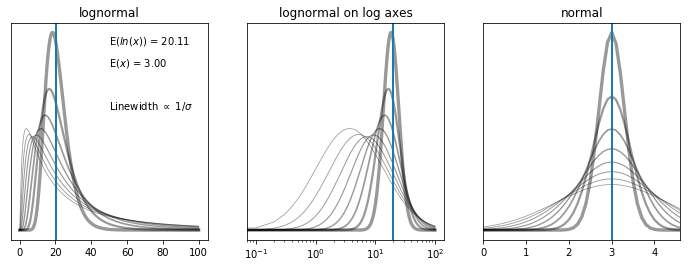

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
mu = 3
x = np.linspace(0, 100, 1000)
explogxs = []
expxs = []
for sigma in np.linspace(0.3, 1.3, 8):
    # As sigma -> >1 - peak density appears below np.exp
    # As sigma -> 0 - peak density trends towards np.exp(mu)
    logdist = stats.lognorm(sigma, scale=np.exp(mu))
    normdist = stats.norm(loc=mu, scale=sigma)
    
    exp_logx = np.exp(np.mean(np.log(logdist.rvs(100000))))
    explogxs.append(exp_logx)
    expx = np.mean(np.log(logdist.rvs(100000)))
    expxs.append(expx)

    ax[0].plot(x, logdist.pdf(x), 'k-', lw=1/sigma, alpha=0.4,)
    ax[0].axvline(exp_logx)
    
    ax[1].plot(x, logdist.pdf(x), 'k-', lw=1/sigma, alpha=0.4,)
    ax[1].axvline(exp_logx)
    
    ax[2].plot(x, normdist.pdf(x), 'k-', lw=1/sigma, alpha=0.4)
    ax[2].axvline(mu)

ax[0].annotate(f'E($ln(x)$) = {np.mean(explogxs):2.2f}', xy=(0.5, 0.9), ha='left', xycoords=ax[0].transAxes)
ax[0].annotate(f'E($x$) = {np.mean(expxs):2.2f}', xy=(0.5, 0.8), ha='left', xycoords=ax[0].transAxes)
ax[0].annotate('Linewidth $\propto$ 1/$\sigma$', xy=(0.5, 0.6), ha='left', xycoords=ax[0].transAxes)
ax[1].set_xscale('log')
ax[2].set_xlim((0, np.log(x.max())))
for a, t in zip(ax, ['lognormal', 'lognormal on log axes', 'normal']):
    a.set_yticks([])
    a.set_title(t)

Log-transformations of relative compositional components allow the use standard statistical techniques, with values previously constrained to $\mathbb{R}\in[0,1]$ now spread over $\mathbb{R}\in[-\infty,\infty] \equiv \mathbb{R}$. Of the log transforms, the additive log ratio (ALR) transform is one of most commonly used. It uses one component as a divisor, and taking logarithms of the relative component abundances:

$alr(x) = [ln(\frac{x_1}{x_d}),ln(\frac{x_2}{x_d}), ..., ln(\frac{x_{d-1}}{x_d})])$

Where the log-transformed variable $Y$ is composed of logarithms of the components of $X$ relative to a chosen divisor component $x_i$. The inverse of this transform is:

$invalr(y) = C([e^{y_1}, e^{y_2},... e^{y_{d-1}}, e^{1_d}])$

Where C denotes the closure operator (i.e. maintaining the 100% sum constraint). Below the invertability of this transformation is demonstrated - provided that closure is considered. The covariance structure may be sensitive to the specific divisor chosen.

In [4]:
sample_xs = [np.array([0.15, 0.3, 0.5, 0.051]).T,
             np.array([[0.2, 0.25, 0.5, 0.05],
                       [0.15, 0.3, 0.5, 0.051]])]

for ind in [0, 1, 2, 3, -1]:
    for xs in sample_xs:
        Y = additive_log_ratio(xs, ind=ind)
        X = inverse_additive_log_ratio(Y, ind=ind)
        assert np.isclose(close(xs), X).all()

Another common log-transformation is the centred log transform (CLR), which instead uses the geometric mean as the divisor:

$clr(x) = [ln(\frac{x_1}{g(x)}),ln(\frac{x_2}{g(x)}), ..., ln(\frac{x_{d-1}}{g(x)})]) = ln(\frac{x}{g(x)})$ where $g(x)$ is the geometric mean $[x_1, x_2, ..., x_D]^{1/D}$

Notably, this transformation uses a single unbiased measure as the divisor - and hence will return a specific covariance structure.

## Visualising Compositional Data

#### Ternary Diagrams

Ternary diagrams are a standard method of visualising compositional data in geology. Typically limited to three components, they can be extended to tetrahedra, albeit with limited utility. While a valid and familar visualisation tool, they incorporate distortion due to the projection. One method to reduce this is centering - where data are perturbed to project the range across the diagram more effectively (e.g. Martin-Fernandez et al., 1999 and von Eynatten et al., 2002). The example below is from von Eynatten et al. (2002; Figure 2), and illustrates how variablity can be better equalized using a centering operation.

![vonEynattenFigure](images/vonEynatten2002Fig2.png)

### Biplots

Biplots utilise principial component analysis to maximise the information presented in a diagram. They illustrate the pattern of relative variation of a multivariate dataset through projection onto a plane defined two principal components -both samples and variables can be represented on biplots.

## Compositional Distance

Due to the constraints of a closed space, euclidean distances in the simplex are not accurate measures of similarity. Instead, distance metrics should be taken from log-transformed data. This is particularly important for clustering, but also has implications for regression (e.g. incorporating least-squares or similar metrics). The figure below highlights this, with three compositional random distributions in the ternary space, for which each is equally separated and has equal variance in log-transformed space. Figure taken from Martin-Fernandez, et al. (1999; Figure 1).

The distance between two compositions $\Delta_s(x, X)$ is given by (Aitchison et al., 2000):

$\Delta_s(x, X) = \bigg[ \sum_{i=1}^{D}\big\{ln\frac{x_i}{g(x)} - ln\frac{X_i}{g(X)}\big\}^2 \bigg]^{1/2}$ where $g(x)$ is the geometric mean $[x_1, x_2, ..., x_D]^{1/D}$

Or, equivalently:

$\Delta_s(x, X) = \bigg[ \frac{1}{D} \sum_{i<j}\big\{ln\frac{x_i}{x_j} - ln\frac{X_i}{X_j}\big\}^2 \bigg]^{1/2}$

![MartinFernandezFigure](images/Martin-FernandezFig1.png)